# Support Vector Machines — Tutorial and Examples

This notebook includes theory (with formulas), practical guidance, and runnable examples using `scikit-learn`.

**Sections**
1. Introduction & prerequisites
2. Linear SVM: hard margin and soft margin (intuition + math)
3. The dual problem & kernel trick
4. Practical notes (scaling, hyperparameters, multiclass)
5. Examples with `scikit-learn` (linear, polynomial, RBF) + visualization
6. Tips, common pitfalls

## Prerequisites

Run the following cell to install any missing packages (only needed if you don't already have them).

```python
# Only run if needed:
# !pip install numpy scipy scikit-learn matplotlib notebook
```

We will use:
- `numpy` for numerical operations
- `matplotlib` for plotting
- `scikit-learn` for SVM implementations and utilities


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
np.random.seed(0)

# Make plots inline in notebooks
%matplotlib inline

## 1) Introduction & Intuition

Support Vector Machines (SVMs) are supervised learning models used for classification and regression. 
At their core, SVMs find a decision boundary (hyperplane) that separates classes with the **maximum margin**.

**Intuition:** For linearly separable data, there are infinitely many separating hyperplanes. SVM chooses the one that maximizes the distance to the nearest training points. Those nearest points are called **support vectors** and determine the classifier.

SVMs can also handle non-linearly separable data by:
- Introducing **slack variables** (soft margin) to allow some misclassification, and/or
- Using the **kernel trick** to implicitly map data into a higher-dimensional feature space where a linear separator exists.


## 2) Linear SVM — Hard Margin (Mathematical formulation)

Given a dataset $\{(x_i, y_i)\}_{i=1}^n$ with $x_i \in \mathbb{R}^d$ and labels $y_i \in \{-1, +1\}$, a linear classifier has form:
\begin{align*}
f(x) &= \mathbf{w}^\top x + b
\end{align*}

For perfectly separable data, the **hard-margin SVM** solves:
\begin{align*}
\min_{\mathbf{w}, b}\quad & \frac{1}{2}\|\mathbf{w}\|^2 \\[6pt]
\text{subject to}\quad & y_i(\mathbf{w}^\top x_i + b) \ge 1,\quad i=1,\dots,n.
\end{align*}

Maximizing the margin is equivalent to minimizing $\tfrac{1}{2}\|\mathbf{w}\|^2$ while keeping all points correctly classified with margin at least 1.


## 3) Soft Margin, Slack Variables, and Hinge Loss

When data is not perfectly separable we introduce slack variables $\xi_i \ge 0$ and trade off margin size with misclassification. The **soft-margin SVM** solves:
\begin{align*}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\[6pt]
\text{subject to}\quad & y_i(\mathbf{w}^\top x_i + b) \ge 1 - \xi_i,\quad \xi_i \ge 0, \quad i=1,\dots,n.
\end{align*}

Here, $C > 0$ is a **regularization parameter** controlling the penalty for violations:
- Large $C$ → less regularization, stricter on misclassification (may overfit).
- Small $C$ → more regularization, wider margin allowed (may underfit).

The soft-margin objective is also equivalent to minimizing empirical hinge loss plus a regularizer:
\begin{align*}
\min_{\mathbf{w},b}\quad \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{i=1}^n \max\big(0,\;1 - y_i(\mathbf{w}^\top x_i + b)\big).
\end{align*}
The hinge loss for one example is $\ell_{\text{hinge}}(y, f(x)) = \max(0, 1 - y f(x))$.


## 4) Dual Problem and the Kernel Trick (Short)

Solving the SVM via the **dual** gives an optimization in terms of Lagrange multipliers $\alpha_i$:
\begin{align*}
\max_{\boldsymbol{\alpha}}\quad & \sum_{i=1}^n \alpha_i - \tfrac{1}{2}\sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j \langle x_i, x_j\rangle \\[6pt]
\text{subject to}\quad & 0 \le \alpha_i \le C, \quad \sum_{i=1}^n \alpha_i y_i = 0.
\end{align*}

The dual depends only on inner products $\langle x_i, x_j\rangle$. Replace this inner product with a kernel function $K(x_i, x_j)=\langle \phi(x_i), \phi(x_j)\rangle$ to implicitly work in a high-dimensional feature space without computing $\phi$ explicitly. This is the **kernel trick**.

Common kernels:
- Linear: $K(x, x') = x^\top x'$
- Polynomial: $K(x, x') = ( \gamma\, x^\top x' + r )^d$
- RBF / Gaussian: $K(x, x') = \exp(-\gamma \|x-x'\|^2)$ where $\gamma>0$

The decision function uses only support vectors with $\alpha_i > 0$:
\begin{align*}
f(x) = \mathrm{sign}\Big(\sum_{i \in \mathcal{S}} \alpha_i y_i K(x_i, x) + b\Big)
\end{align*}
where $\mathcal{S}$ denotes the support vectors.


## 5) Practical Notes and Tips

- **Feature scaling:** SVMs are sensitive to feature scales. Always scale features (e.g., `StandardScaler`) before training, especially for RBF and polynomial kernels.
- **Hyperparameters:** `C` (regularization), `kernel` (linear/poly/rbf), `gamma` (for RBF/poly), `degree` (for polynomial). Use cross-validation to tune them (e.g., `GridSearchCV`). 
- **Sparsity of solution:** Only support vectors matter for prediction; this can make prediction faster when the number of support vectors is small.
- **Multiclass:** `scikit-learn` uses a one-vs-one strategy for `SVC` by default; `LinearSVC` uses one-vs-rest by default. Use whichever fits your problem and performance needs.
- **Probabilities:** To get probability estimates use `probability=True` in `SVC` (this uses cross-validation internally and is slower).


## 6) Example 1 — Linear SVM on a synthetic 2D dataset

We will create a linearly separable toy dataset, train a linear SVM, and visualize the decision boundary and support vectors.


In [2]:
# Create a toy 2D dataset
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, random_state=6, cluster_std=1.2)
y = np.where(y == 0, -1, 1)   # convert labels to -1 and +1 for clarity

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Train linear SVM (using SVC with linear kernel)
clf_lin = svm.SVC(kernel='linear', C=1.0)
clf_lin.fit(X_train_s, y_train)

print('Train acc:', clf_lin.score(X_train_s, y_train))
print('Test acc: ', clf_lin.score(X_test_s, y_test))

Train acc: 1.0
Test acc:  1.0


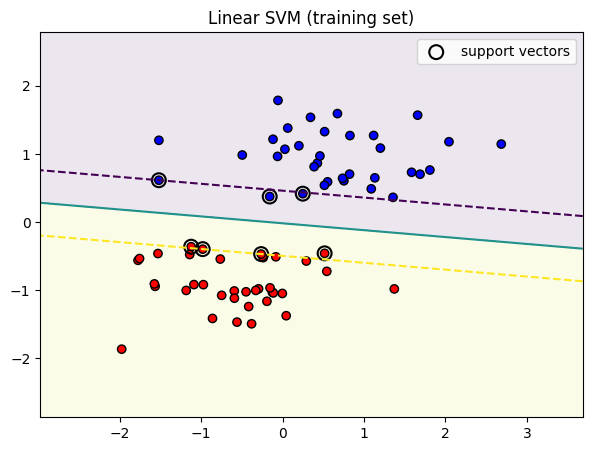

In [3]:
# Plot decision boundary and support vectors
def plot_svc(clf, X, y, ax=None, title='SVM decision boundary'):
    if ax is None:
        ax = plt.gca()
    # create grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    xy = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.decision_function(xy).reshape(xx.shape)
    # plot decision boundary and margins
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--','-','--'])
    ax.contourf(xx, yy, np.sign(Z), alpha=0.1)
    # plot data points
    ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolors='k')
    # support vectors
    sv = clf.support_vectors_
    ax.scatter(sv[:,0], sv[:,1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='support vectors')
    ax.set_title(title)
    ax.legend()

plt.figure(figsize=(7,5))
plot_svc(clf_lin, X_train_s, y_train, title='Linear SVM (training set)')
plt.show()


### Inspect support vectors

In [4]:
print('Number of support vectors for each class:', clf_lin.n_support_)
print('Total support vectors:', len(clf_lin.support_))
print('Support vector indices (in training set):', clf_lin.support_)

Number of support vectors for each class: [3 4]
Total support vectors: 7
Support vector indices (in training set): [ 2 43 55 28 34 49 60]


## 7) Example 2 — Non-linear decision boundary with RBF kernel

Create a dataset that is not linearly separable and show how RBF kernel SVM can separate it.


Train acc: 0.9428571428571428
Test acc:  0.9333333333333333


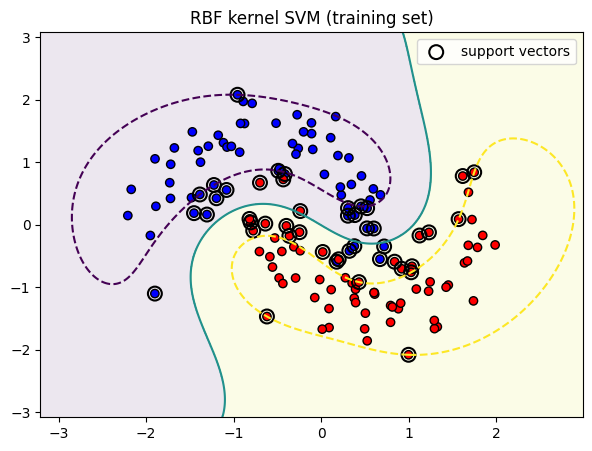

In [6]:
# make_moons dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.2, random_state=0)
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# RBF kernel SVM
clf_rbf = svm.SVC(kernel='rbf', gamma='scale', C=1.0)
clf_rbf.fit(X_train_s, y_train)
print('Train acc:', clf_rbf.score(X_train_s, y_train))
print('Test acc: ', clf_rbf.score(X_test_s, y_test))

plt.figure(figsize=(7,5))
plot_svc(clf_rbf, X_train_s, y_train, title='RBF kernel SVM (training set)')
plt.show()

## 8) Hyperparameter tuning with GridSearchCV

We'll search over `C` and `gamma` (for RBF) using cross-validation. This is often necessary to get good performance.


Best params: {'C': 100, 'gamma': 1}
Best CV score: 0.9714285714285715


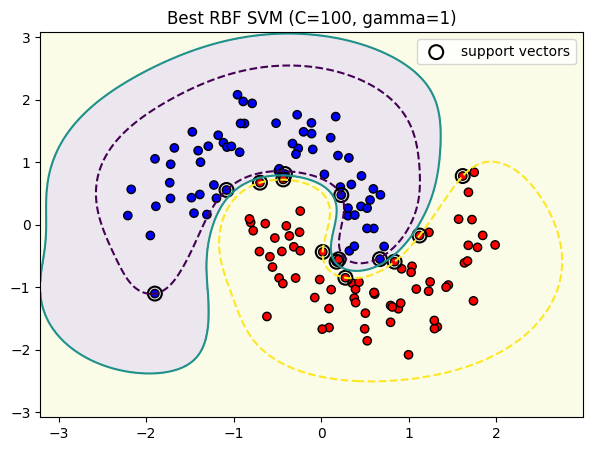

In [8]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_s, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best = grid.best_estimator_
plt.figure(figsize=(7,5))
plot_svc(best, X_train_s, y_train, title=f'Best RBF SVM (C={grid.best_params_["C"]}, gamma={grid.best_params_["gamma"]})')
plt.show()

## 9) Multiclass classification with SVMs

SVMs are inherently binary. `scikit-learn` handles multiclass problems by combining binary classifiers:
- `SVC` uses **one-vs-one** by default (fits classifiers for every pair of classes).
- `LinearSVC` uses **one-vs-rest** by default.

Let's run a small example on the Iris dataset to show multiclass classification with a linear kernel.


In [9]:
iris = datasets.load_iris()
X = iris.data[:, :2]   # take only two features for easy plotting
y = iris.target

# For plotting and clarity we'll keep original labels (0,1,2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

clf_multi = svm.SVC(kernel='linear', C=1.0)
clf_multi.fit(X_train_s, y_train)
print('Test acc:', clf_multi.score(X_test_s, y_test))
print('\\nClassification report:\\n', classification_report(y_test, clf_multi.predict(X_test_s)))

Test acc: 0.8
\nClassification report:\n               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.76      0.72      0.74        18
           2       0.58      0.64      0.61        11

    accuracy                           0.80        45
   macro avg       0.78      0.79      0.78        45
weighted avg       0.80      0.80      0.80        45



## 10) Common Pitfalls & Tips

- **Always scale features** when using kernels (RBF, polynomial). For linear kernel scaling is usually still beneficial.
- **Very large datasets:** SVM training scales between quadratic and cubic in the number of samples depending on implementation — for very large datasets prefer linear models (e.g., `LinearSVC`) or approximate methods (e.g., `SGDClassifier` with hinge loss).
- **Interpretability:** Linear SVMs are more interpretable (weights indicate feature importance), kernel SVMs less so.
- **Kernel choice:** RBF is a good default for many problems; polynomial when you suspect polynomial relationships; linear when data is (approximately) linearly separable or for high-dimensional sparse data (e.g., text).
